## Pre-trained models for image classification

In [2]:
import torch
from PIL import Image
from torchvision import models, transforms
import matplotlib.pyplot as plt

### Download an image and `imagenet_classes.txt`

In [3]:
# sample file
!wget -q https://upload.wikimedia.org/wikipedia/commons/5/55/Hunting_Tiger_Ranthambore.jpg -O tiger.jpg

# the file contains all the classes in the imagenet dataset
# required to extract actual label from the NN
# the label is a number.
!wget -q https://github.com/nmilosev/pytorch-arm-builds/raw/master/imagenet_classes.txt

In [4]:
with open('imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

In [5]:
labels[:5]

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark']

### Initialize the model
- Don't forget to enable the `eval` mode.

In [7]:
net = models.shufflenet_v2_x1_0(pretrained=True) # this model coz it's fast.
net.eval()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

### Normalization

Std. procedure for normalizing ImageNet images. 
- the method is available on PyTorch website
- it's imp. to apply same transformations same as that in the training dataset.

- So we resize the image, crop it, convert it into a tensor and normalizing it.

In [8]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

### Helper method
For inference which receives a `PIL` image and returns top 5 classes.

In [9]:
def infer(img):
    img_t = transform(img) 
    batch_t = torch.unsqueeze(img_t, 0) # convert into input of n/w compatible
    out = net(batch_t) # run image through model

    # code that extracts top 5 labels and percentages
    # top 5 coz otherwise results will be into the thousands
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    _, indices = torch.sort(out, descending=True)
    result = [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]
    return result

### Load Image

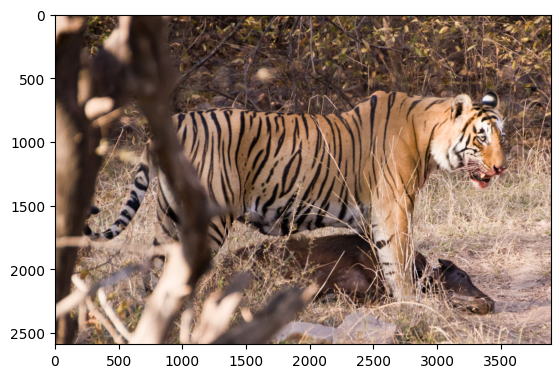

In [10]:
img = Image.open('tiger.jpg')
plt.imshow(img)

### Run the inference

In [11]:
infer(img)

[('tiger, Panthera tigris', 93.22502899169922),
 ('tiger cat', 2.323385238647461),
 ('bull mastiff', 0.776154637336731),
 ('boxer', 0.744747519493103),
 ('Staffordshire bullterrier, Staffordshire bull terrier',
  0.41503891348838806)]

### Exposing the Model



In [16]:
import sys, re, base64, io
from flask import jsonify
from flask import Flask, request